#### Copyright 2019 The TensorFlow Authors.

In [79]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [80]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler




import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif
import numpy as np
from scipy import stats as st
from sklearn.preprocessing import PowerTransformer

In [81]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.set_option('display.max_columns', None)

## Data processing and exploration

In [82]:
df = pd.read_excel(r"data/trainDataset.xls")
df.head(5)

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1,144.0,41.0,0,0,0,1,3,3,1,1,2,0.813912,0.724080,23.781937,32.844370,37.696154,38.626416,34.713110,39.572718,14209.458330,26.732440,0.771675,3676.500012,0.258736,14263,-0.163500,0.708860,2897.68930,0.738088,0.406537,4.594629,2.114799,0.278008,0.248168,0.217628,-1.251833,3.366632,0.174026,0.450734,0.386237,2897.68930,0.670

### Examine the class label imbalance

Let's look at the dataset imbalance:

In [83]:
df = df[df['pCR (outcome)']!=999]

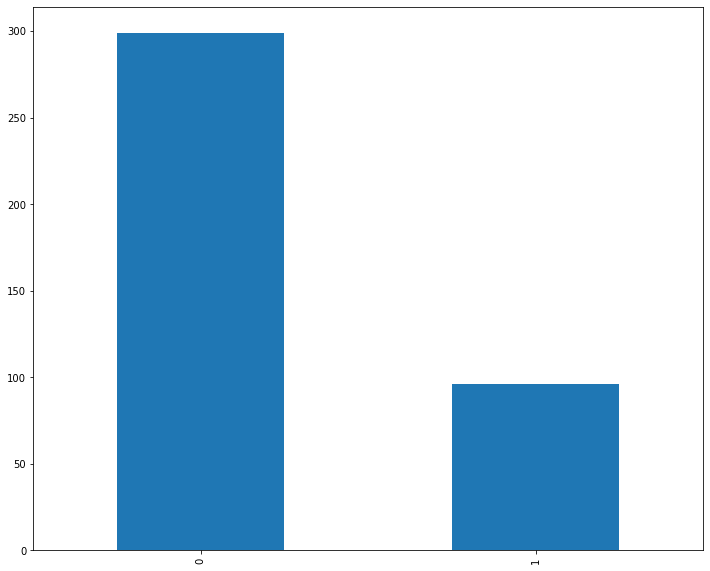

0    0.756962
1    0.243038
Name: pCR (outcome), dtype: float64

In [84]:
df['pCR (outcome)'].value_counts().plot(kind='bar')
plt.show()
df['pCR (outcome)'].value_counts()/df['pCR (outcome)'].shape[0]

In [85]:
neg, pos = df['pCR (outcome)'].value_counts()[0], df['pCR (outcome)'].value_counts()[1]
total = neg + pos

This shows the small fraction of positive samples.

### Data processing

Remove outliers, standardizing, feature selection

In [86]:
float_cols = list(df.select_dtypes(include=['float64']).columns)
float_cols.remove('RelapseFreeSurvival (outcome)') 
float_cols.remove('Age')

In [87]:
def find_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)
    return lower_boundary, upper_boundary

In [88]:
def treat_outliers(df, variable, distance=1.5, inplace=True):
    """ 
    Fill outliers with mean
    
    upper_boundary = 75th qualtile + (IQR * diatance)
    upper_boundary = 25th qualtile - (IQR * diatance)
        
    """
    
    lower_boundary, upper_boundary = find_boundaries(df,variable)
    if inplace:
        df[variable] = np.where(df[variable]>upper_boundary,df[variable].mean(),
                                np.where(df[variable]<lower_boundary,df[variable].mean(),df[variable])
                           )
    else:
        return np.where(df[variable]>upper_boundary,df[variable].mean(),
                                np.where(df[variable]<lower_boundary,df[variable].mean(),df[variable])
                           )

In [89]:
skewness=[]
for col in float_cols:
    treat_outliers(df, col, inplace=True)
    skewness.append((col,df[col].skew()))

In [90]:
transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(df[float_cols])
df_float_cols = pd.DataFrame(transformer.transform(df[float_cols]),columns=float_cols)

C:\Users\chaitanyamanem\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [91]:
post_skewness = []
for col in float_cols:
    post_skewness.append((col,df_float_cols[col].skew()))
        
post_skewness_df = pd.DataFrame(post_skewness,columns=['feature','skewness_score'])
post_skewness_df.sort_values(by='skewness_score',ascending=False,inplace=True)
post_skewness_df.head(3)

,feature,skewness_score
102,original_ngtdm_Coarseness,1.892875
105,original_ngtdm_Strength,0.631977
104,original_ngtdm_Contrast,0.333569


In [92]:
transformed_float_cols = post_skewness_df[(post_skewness_df['skewness_score']>-0.5) & (post_skewness_df['skewness_score']<0.5)]['feature'].to_list()
df_float_cols = df_float_cols[transformed_float_cols]
df_float_cols.head()

,original_ngtdm_Contrast,original_glcm_SumSquares,original_glcm_ClusterTendency,original_glcm_ClusterProminence,original_gldm_LowGrayLevelEmphasis,original_gldm_GrayLevelVariance,original_glrlm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glcm_InverseVariance,original_glcm_DifferenceAverage,original_glcm_Contrast,original_ngtdm_Complexity,original_glszm_ZoneVariance,original_glcm_DifferenceVariance,original_glszm_ZonePercentage,original_glrlm_RunLengthNonUniformityNormalized,original_glcm_SumEntropy,original_glcm_JointEntropy,original_firstorder_Entropy,original_glszm_SizeZoneNonUniformityNormalized,original_firstorder_Variance,original_glcm_Imc2,original_glcm_ClusterShade,original_gldm_SmallDependenceEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_glszm_SmallAreaEmphasis,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glszm_SizeZoneNonUniformity,original_firstorder_Kurtosis,original_shape_SurfaceVolumeRatio,original_firstorder_MeanAbsoluteDeviation,original_firstorder_RobustMeanAbsoluteDeviation,original_glszm_LargeAreaEmphasis,original_firstorder_Skewness,original_gldm_DependenceNonUniformityNormalized,original_firstorder_Maximum,original_glcm_DifferenceEntropy,original_glszm_LargeAreaHighGrayLevelEmphasis,original_firstorder_10Percentile,original_firstorder_Range,original_glrlm_ShortRunHighGrayLevelEmphasis,original_firstorder_Mean,original_firstorder_RootMeanSquared,original_firstorder_Median,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glcm_Correlation,original_glcm_MCC,original_firstorder_90Percentile,original_firstorder_Minimum,original_glcm_Imc1,original_gldm_DependenceEntropy,original_glrlm_RunEntropy,original_firstorder_InterquartileRange,original_shape_MajorAxisLength,original_shape_MinorAxisLength,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterColumn,original_glrlm_ShortRunEmphasis,original_shape_LeastAxisLength,original_shape_Maximum3DDiameter,original_shape_Maximum2DDiameterSlice,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_DependenceVariance,original_glrlm_RunVariance,original_shape_SurfaceArea,original_glrlm_LongRunHighGrayLevelEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_glrlm_RunLengthNonUniformity,original_glrlm_GrayLevelNonUniformity,original_shape_Flatness,original_glszm_GrayLevelNonUniformity,original_shape_MeshVolume,original_glrlm_HighGrayLevelRunEmphasis,original_gldm_GrayLevelNonUniformity,original_firstorder_TotalEnergy,original_firstorder_Energy,original_glszm_ZoneEntropy,original_shape_Sphericity,original_gldm_DependenceNonUniformity,original_shape_Elongation,original_glcm_Idmn,original_glcm_Idn,original_glcm_Idm,original_glcm_Id,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_GrayLevelNonUniformityNormalized,original_glcm_JointEnergy,original_glcm_Autocorrelation,original_glcm_JointAverage,original_glcm_SumAverage,original_firstorder_Uniformity,original_gldm_HighGrayLevelEmphasis,original_glcm_MaximumProbability,original_ngtdm_Busyness,original_glrlm_GrayLevelVariance
0,0.815584,0.394809,0.504747,1.693400,1.881015,1.797994,-1.312548,0.990509,0.997332,0.249831,0.249831,0.249831,2.139064,-0.013155,2.110280,-0.277370,1.457461,1.893302,1.931494,1.689474,-0.405175,-2.243220,1.378533,-1.785998,0.140494,0.829315,-0.308556,0.086117,-0.091224,1.809329,1.287389,0.118759,0.166203,0.361468,-1.236164,-2.520336,-2.449599,0.021062,1.604314,-1.866521,-2.205560,2.076385,0.017873,-1.104284,-1.546236,2.244434,0.224215,0.278809,0.172390,0.0,0.902403,0.837670,0.834537,0.240085,-0.428112,-0.460296,2.300923,-0.234121,-2.370339,-0.4

### Finding pointbiserialr correlation between FLoat columns and 'pCR (outcome)'

In [93]:
correlation = []

for col in list(df_float_cols.columns):
    correlation.append((col,abs(st.pointbiserialr(df['pCR (outcome)'],df_float_cols[col]).correlation)))

float_cols_correlation_df = pd.DataFrame(correlation,columns=['feature','correlation'])
float_cols_correlation_df.sort_values(by='correlation',ascending=False,inplace=True)

final_selected_float_cols = float_cols_correlation_df[abs(float_cols_correlation_df['correlation'])>0.13]['feature'].to_list()

final_continuous_features_df = df_float_cols[final_selected_float_cols]
final_continuous_features_df.head(3)

C:\Users\chaitanyamanem\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,original_glrlm_RunPercentage,original_glrlm_LongRunLowGrayLevelEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_glrlm_RunLengthNonUniformityNormalized,original_gldm_LargeDependenceEmphasis,original_glrlm_RunEntropy,original_glrlm_LongRunEmphasis,original_gldm_DependenceEntropy,original_glrlm_RunVariance,original_ngtdm_Contrast,original_firstorder_TotalEnergy,original_firstorder_Energy,original_glrlm_LongRunHighGrayLevelEmphasis,original_glcm_MaximumProbability,original_firstorder_10Percentile
0,1.809329,-1.001900,-2.014558,1.457461,-1.830925,-0.234121,-1.143650,2.300923,-0.627258,0.815584,-1.822729,-1.822729,-1.041581,-0.378908,-1.104284
1,-0.865203,0.827094,1.001130,-0.813269,0.905911,0.780899,0.939034,-0.988042,0.844573,-0.701162,0.254132,0.254132,0.982890,0.578373,0.708810
2,-0.864054,0.642440,0.965911,-0.969414,0.864701,0.719790,0.754650,-0.850452,0.557812,-0.920492,-0.460947,-0.460947,0.800122,0.819227,0.653180


### Merging categorical can continuous features

In [94]:
X = pd.concat([final_continuous_features_df.reset_index(),df[['ER', 'PgR', 'HER2', 'LNStatus']].reset_index()],axis=1)
y = df['pCR (outcome)']
X.drop(columns=['index'],inplace=True)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

### Scaling the data

In [96]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [97]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.45),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds. 

Note: Accuracy is not a helpful metric for this task. You can have 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [98]:
EPOCHS = 100


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [99]:
model = make_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 16)                320       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


Test run the model:

In [100]:
model.predict(X_train.iloc[:10,:])

1/1 [==============================] - 0s 64ms/step


array([[0.6897335 ],
       [0.78872406],
       [0.82592773],
       [0.97758293],
       [0.7629109 ],
       [0.9673305 ],
       [0.7857496 ],
       [0.7445268 ],
       [0.97523797],
       [0.81155765]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [101]:
results = model.evaluate(X_train, y_train,verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.5087


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [102]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.13609538])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [103]:
model = make_model(output_bias=initial_bias)
model.predict(X_train.iloc[:10,:])

1/1 [==============================] - 0s 57ms/step


array([[0.40949512],
       [0.4751562 ],
       [0.6000965 ],
       [0.1592628 ],
       [0.42734626],
       [0.16175875],
       [0.39460596],
       [0.46784967],
       [0.10446035],
       [0.6047507 ]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [104]:
results = model.evaluate(X_train, y_train,verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7217


This initial loss is about 50 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [105]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [106]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,    
    epochs=20,
    validation_data=(X_test, y_test), 
    verbose=0)

In [107]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,    
    epochs=20,
    validation_data=(X_test, y_test), 
    verbose=0)

In [108]:
def plot_loss(history, label, n):
      # Use a log scale on y-axis to show the wide range of values.
      plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
      plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
      plt.legend()
    
      plt.xlabel('Epoch')
      plt.ylabel('Loss')

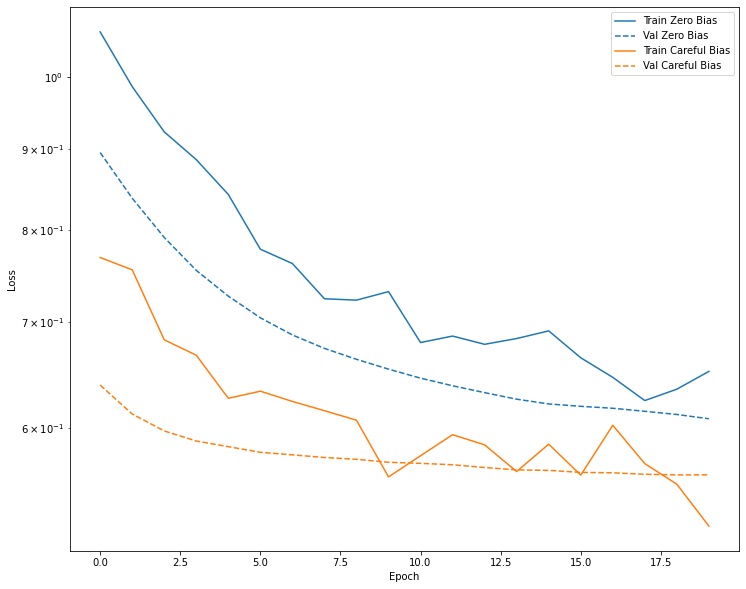

In [109]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [110]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test))

Epoch 1/100
10/10 [==============================] - 3s 127ms/step - loss: 0.7923 - tp: 16.0000 - fp: 56.0000 - tn: 243.0000 - fn: 80.0000 - accuracy: 0.6557 - precision: 0.2222 - recall: 0.1667 - auc: 0.4498 - prc: 0.2383 - val_loss: 0.6364 - val_tp: 1.0000 - val_fp: 10.0000 - val_tn: 65.0000 - val_fn: 23.0000 - val_accuracy: 0.6667 - val_precision: 0.0909 - val_recall: 0.0417 - val_auc: 0.4372 - val_prc: 0.2068
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 0.7594 - tp: 15.0000 - fp: 66.0000 - tn: 158.0000 - fn: 57.0000 - accuracy: 0.5845 - precision: 0.1852 - recall: 0.2083 - auc: 0.4512 - prc: 0.2169 - val_loss: 0.6101 - val_tp: 0.0000e+00 - val_fp: 4.0000 - val_tn: 71.0000 - val_fn: 24.0000 - val_accuracy: 0.7172 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4528 - val_prc: 0.2118
Epoch 3/100
10/10 [==============================] - 0s 21ms/step - loss: 0.7039 - tp: 19.0000 - fp: 55.0000 - tn: 169.0000 - fn: 53.0000 - accuracy: 0.6351

Epoch 40/100
10/10 [==============================] - 0s 20ms/step - loss: 0.5105 - tp: 12.0000 - fp: 11.0000 - tn: 213.0000 - fn: 60.0000 - accuracy: 0.7601 - precision: 0.5217 - recall: 0.1667 - auc: 0.6911 - prc: 0.4220 - val_loss: 0.5670 - val_tp: 3.0000 - val_fp: 3.0000 - val_tn: 72.0000 - val_fn: 21.0000 - val_accuracy: 0.7576 - val_precision: 0.5000 - val_recall: 0.1250 - val_auc: 0.5611 - val_prc: 0.3169
Epoch 41/100
10/10 [==============================] - 0s 19ms/step - loss: 0.5039 - tp: 13.0000 - fp: 7.0000 - tn: 217.0000 - fn: 59.0000 - accuracy: 0.7770 - precision: 0.6500 - recall: 0.1806 - auc: 0.6981 - prc: 0.4652 - val_loss: 0.5673 - val_tp: 3.0000 - val_fp: 3.0000 - val_tn: 72.0000 - val_fn: 21.0000 - val_accuracy: 0.7576 - val_precision: 0.5000 - val_recall: 0.1250 - val_auc: 0.5619 - val_prc: 0.3156
Epoch 42/100
10/10 [==============================] - 0s 19ms/step - loss: 0.5192 - tp: 12.0000 - fp: 7.0000 - tn: 217.0000 - fn: 60.0000 - accuracy: 0.7736 - precision:

### Check training history

In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in the [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) tutorial.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [111]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

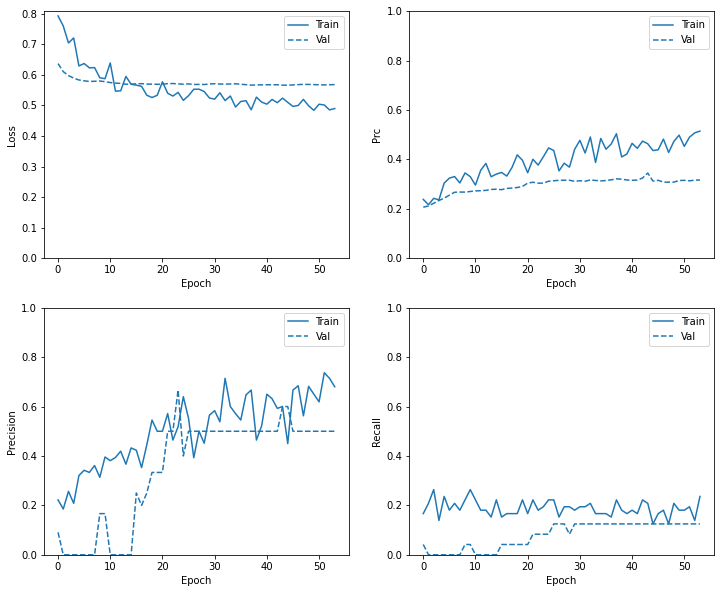

In [112]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [113]:
train_predictions_baseline = model.predict(X_train)
test_predictions_baseline = model.predict(X_test)

4/4 [==============================] - 0s 3ms/step


In [114]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above:

loss :  0.5660422444343567
tp :  3.0
fp :  2.0
tn :  73.0
fn :  21.0
accuracy :  0.7676767706871033
precision :  0.6000000238418579
recall :  0.125
auc :  0.5633333325386047
prc :  0.34501466155052185

Legitimate Transactions Detected (True Negatives):  73
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  21
Fraudulent Transactions Detected (True Positives):  3
Total Fraudulent Transactions:  24


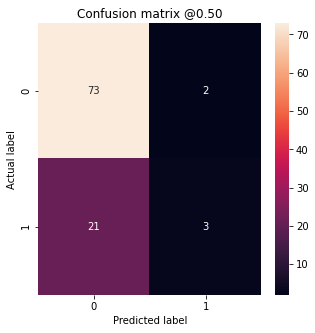

In [115]:
baseline_results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [116]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-0.5,20])
  #plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

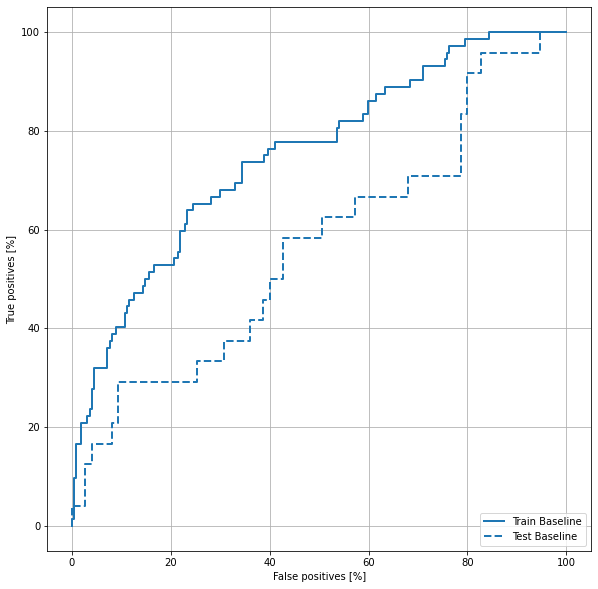

In [117]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC

Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


In [40]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

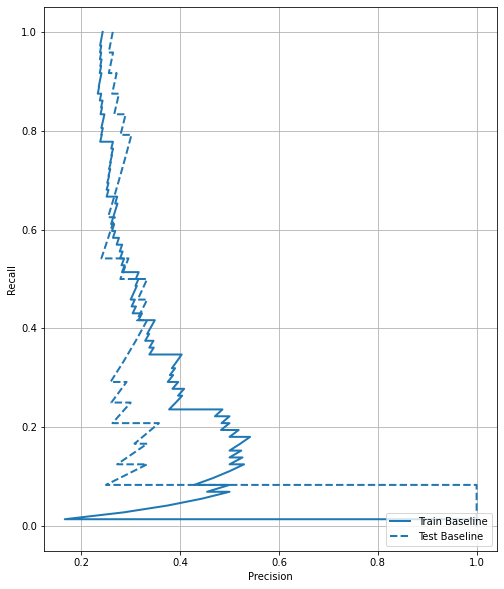

In [41]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [214]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test,test_predictions_baseline)

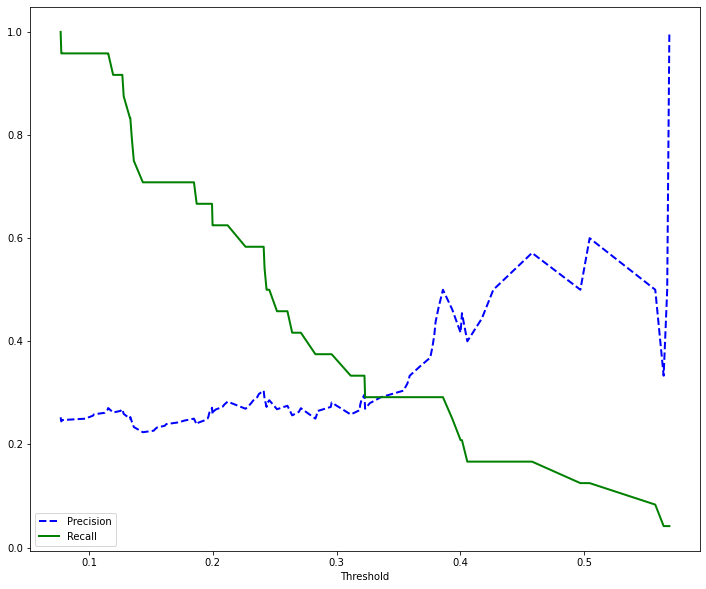

In [215]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
#plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
#[...]  # beautify the figure: add grid, legend, axis, labels, and circles
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [216]:
idx_for_95_recall = recalls[recalls>=0.958].shape[0]-1
threshold_for_95_recall = thresholds[idx_for_95_recall]
print(f" Threshold for 75% recall {threshold_for_95_recall}")
print(f"Precision: {precisions[idx_for_95_recall]}")
print(f"Recall: {recalls[idx_for_95_recall]}")


 Threshold for 75% recall 0.11545625329017639
Precision: 0.27058823529411763
Recall: 0.9583333333333334


In [217]:
confusion_matrix(y_test,np.where(test_predictions_baseline > idx_for_95_recall,1,0))

array([[75,  0],
       [24,  0]], dtype=int64)

Legitimate Transactions Detected (True Negatives):  75
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  24
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  24


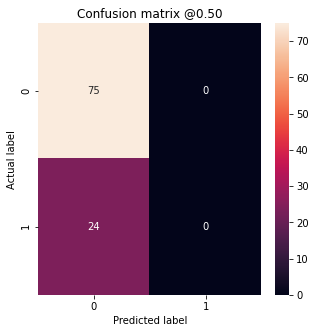

In [218]:
plot_cm(y_test, np.where(test_predictions_baseline > idx_for_95_recall,1,0))

In [220]:
precisions

array([0.25263158, 0.24468085, 0.24731183, 0.25      , 0.25274725,
       0.25555556, 0.25842697, 0.26136364, 0.26436782, 0.26744186,
       0.27058824, 0.26190476, 0.26506024, 0.26829268, 0.25925926,
       0.25      , 0.25316456, 0.24358974, 0.23376623, 0.22368421,
       0.22666667, 0.22972973, 0.23287671, 0.23611111, 0.23943662,
       0.24285714, 0.24637681, 0.25      , 0.23880597, 0.24242424,
       0.24615385, 0.25      , 0.25396825, 0.25806452, 0.26229508,
       0.26666667, 0.27118644, 0.25862069, 0.26315789, 0.26785714,
       0.27272727, 0.27777778, 0.28301887, 0.26923077, 0.2745098 ,
       0.28      , 0.28571429, 0.29166667, 0.29787234, 0.30434783,
       0.28888889, 0.27272727, 0.27906977, 0.28571429, 0.26829268,
       0.275     , 0.25641026, 0.26315789, 0.27027027, 0.25      ,
       0.25714286, 0.26470588, 0.27272727, 0.28125   , 0.25806452,
       0.26666667, 0.27586207, 0.28571429, 0.2962963 , 0.26923077,
       0.28      , 0.29166667, 0.30434783, 0.31818182, 0.33333

In [225]:
recalls

array([1.        , 0.95833333, 0.95833333, 0.95833333, 0.95833333,
       0.95833333, 0.95833333, 0.95833333, 0.95833333, 0.95833333,
       0.95833333, 0.91666667, 0.91666667, 0.91666667, 0.875     ,
       0.83333333, 0.83333333, 0.79166667, 0.75      , 0.70833333,
       0.70833333, 0.70833333, 0.70833333, 0.70833333, 0.70833333,
       0.70833333, 0.70833333, 0.70833333, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.625     , 0.625     , 0.625     ,
       0.625     , 0.625     , 0.625     , 0.58333333, 0.58333333,
       0.58333333, 0.58333333, 0.58333333, 0.58333333, 0.58333333,
       0.54166667, 0.5       , 0.5       , 0.5       , 0.45833333,
       0.45833333, 0.41666667, 0.41666667, 0.41666667, 0.375     ,
       0.375     , 0.375     , 0.375     , 0.375     , 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.29166667,
       0.29166667, 0.29166667, 0.29166667, 0.29166667, 0.29166

In [222]:
thresholds

array([0.07701969, 0.07756533, 0.07838825, 0.09727777, 0.09980319,
       0.10292304, 0.10405537, 0.11258928, 0.11378869, 0.11495787,
       0.11545625, 0.11943076, 0.12540522, 0.12687275, 0.12797417,
       0.13298361, 0.13331328, 0.13460614, 0.13616149, 0.1434508 ,
       0.15218273, 0.15336967, 0.15493862, 0.16099834, 0.16240257,
       0.1724107 , 0.1771662 , 0.18473347, 0.18693572, 0.18843684,
       0.1926816 , 0.19567904, 0.1964506 , 0.19677384, 0.19730687,
       0.19879782, 0.1993217 , 0.19975877, 0.20007293, 0.20241722,
       0.20768194, 0.2094756 , 0.21193098, 0.22641556, 0.22887622,
       0.23089293, 0.23279239, 0.23586689, 0.23721722, 0.24106508,
       0.24176575, 0.24340641, 0.24362019, 0.24560542, 0.25181377,
       0.26023853, 0.26409888, 0.26947707, 0.27110195, 0.28286207,
       0.28387287, 0.28446627, 0.2952684 , 0.29596868, 0.31137723,
       0.31875676, 0.3189585 , 0.31996813, 0.32248953, 0.32301208,
       0.32678795, 0.33584213, 0.35402697, 0.35717884, 0.35907

In [224]:
0.1/(0.1+24)

0.004149377593360996

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [118]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total )

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.66
Weight for class 1: 4.11


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [119]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,    
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
10/10 [==============================] - 3s 141ms/step - loss: 1.5947 - tp: 25.0000 - fp: 72.0000 - tn: 227.0000 - fn: 71.0000 - accuracy: 0.6380 - precision: 0.2577 - recall: 0.2604 - auc: 0.4996 - prc: 0.2496 - val_loss: 0.6709 - val_tp: 4.0000 - val_fp: 19.0000 - val_tn: 56.0000 - val_fn: 20.0000 - val_accuracy: 0.6061 - val_precision: 0.1739 - val_recall: 0.1667 - val_auc: 0.4278 - val_prc: 0.2038
Epoch 2/100
10/10 [==============================] - 0s 21ms/step - loss: 1.4863 - tp: 24.0000 - fp: 67.0000 - tn: 157.0000 - fn: 48.0000 - accuracy: 0.6115 - precision: 0.2637 - recall: 0.3333 - auc: 0.4686 - prc: 0.2262 - val_loss: 0.6636 - val_tp: 5.0000 - val_fp: 19.0000 - val_tn: 56.0000 - val_fn: 19.0000 - val_accuracy: 0.6162 - val_precision: 0.2083 - val_recall: 0.2083 - val_auc: 0.4408 - val_prc: 0.2066
Epoch 3/100
10/10 [==============================] - 0s 21ms/step - loss: 1.5016 - tp: 20.0000 - fp: 71.0000 - tn: 153.0000 - fn: 52.0000 - accuracy: 0.5845 - precisio

Epoch 21/100
10/10 [==============================] - 0s 21ms/step - loss: 0.9334 - tp: 55.0000 - fp: 128.0000 - tn: 96.0000 - fn: 17.0000 - accuracy: 0.5101 - precision: 0.3005 - recall: 0.7639 - auc: 0.6682 - prc: 0.4202 - val_loss: 0.8404 - val_tp: 15.0000 - val_fp: 44.0000 - val_tn: 31.0000 - val_fn: 9.0000 - val_accuracy: 0.4646 - val_precision: 0.2542 - val_recall: 0.6250 - val_auc: 0.5308 - val_prc: 0.2875
Epoch 22/100
10/10 [==============================] - 0s 19ms/step - loss: 0.9209 - tp: 54.0000 - fp: 109.0000 - tn: 115.0000 - fn: 18.0000 - accuracy: 0.5709 - precision: 0.3313 - recall: 0.7500 - auc: 0.6821 - prc: 0.4417 - val_loss: 0.8423 - val_tp: 15.0000 - val_fp: 44.0000 - val_tn: 31.0000 - val_fn: 9.0000 - val_accuracy: 0.4646 - val_precision: 0.2542 - val_recall: 0.6250 - val_auc: 0.5306 - val_prc: 0.2932
Epoch 23/100
10/10 [==============================] - 0s 27ms/step - loss: 0.9928 - tp: 52.0000 - fp: 109.0000 - tn: 115.0000 - fn: 20.0000 - accuracy: 0.5642 - prec

Epoch 41/100
10/10 [==============================] - 0s 20ms/step - loss: 0.9174 - tp: 49.0000 - fp: 106.0000 - tn: 118.0000 - fn: 23.0000 - accuracy: 0.5642 - precision: 0.3161 - recall: 0.6806 - auc: 0.6883 - prc: 0.4497 - val_loss: 0.8552 - val_tp: 15.0000 - val_fp: 43.0000 - val_tn: 32.0000 - val_fn: 9.0000 - val_accuracy: 0.4747 - val_precision: 0.2586 - val_recall: 0.6250 - val_auc: 0.5406 - val_prc: 0.3111
Epoch 42/100
10/10 [==============================] - 0s 19ms/step - loss: 0.9488 - tp: 54.0000 - fp: 115.0000 - tn: 109.0000 - fn: 18.0000 - accuracy: 0.5507 - precision: 0.3195 - recall: 0.7500 - auc: 0.6736 - prc: 0.3803 - val_loss: 0.8558 - val_tp: 15.0000 - val_fp: 43.0000 - val_tn: 32.0000 - val_fn: 9.0000 - val_accuracy: 0.4747 - val_precision: 0.2586 - val_recall: 0.6250 - val_auc: 0.5431 - val_prc: 0.3119
Epoch 43/100
10/10 [==============================] - 0s 19ms/step - loss: 0.9518 - tp: 54.0000 - fp: 118.0000 - tn: 106.0000 - fn: 18.0000 - accuracy: 0.5405 - pre

### Check training history

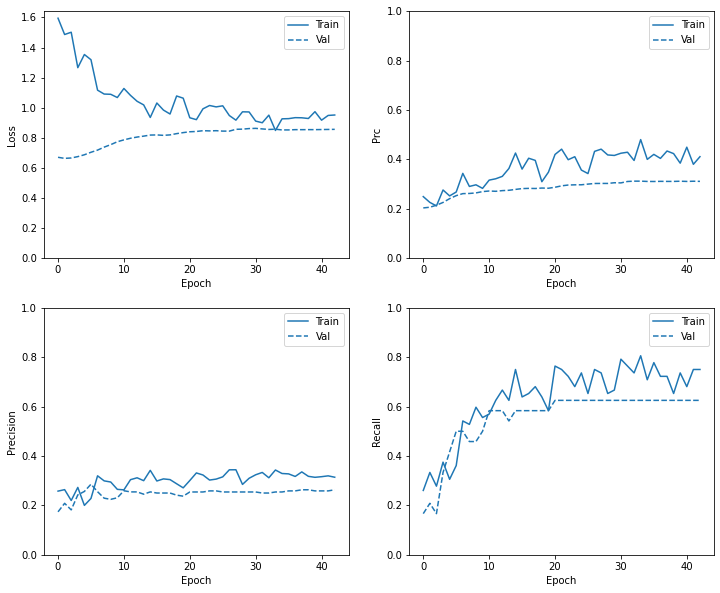

In [120]:
plot_metrics(weighted_history)

### Evaluate metrics

In [121]:
train_predictions_weighted = weighted_model.predict(X_train)
test_predictions_weighted = weighted_model.predict(X_test)

4/4 [==============================] - 0s 2ms/step


loss :  0.8557107448577881
tp :  15.0
fp :  45.0
tn :  30.0
fn :  9.0
accuracy :  0.4545454680919647
precision :  0.25
recall :  0.625
auc :  0.5433333516120911
prc :  0.3122093081474304

Legitimate Transactions Detected (True Negatives):  30
Legitimate Transactions Incorrectly Detected (False Positives):  45
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  15
Total Fraudulent Transactions:  24


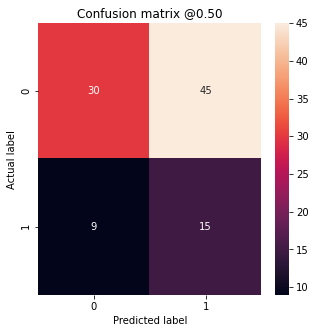

In [122]:
weighted_results = weighted_model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

### Plot Precision and recall curve

In [130]:
y_test.shape

(99,)

In [135]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test,test_predictions_weighted)

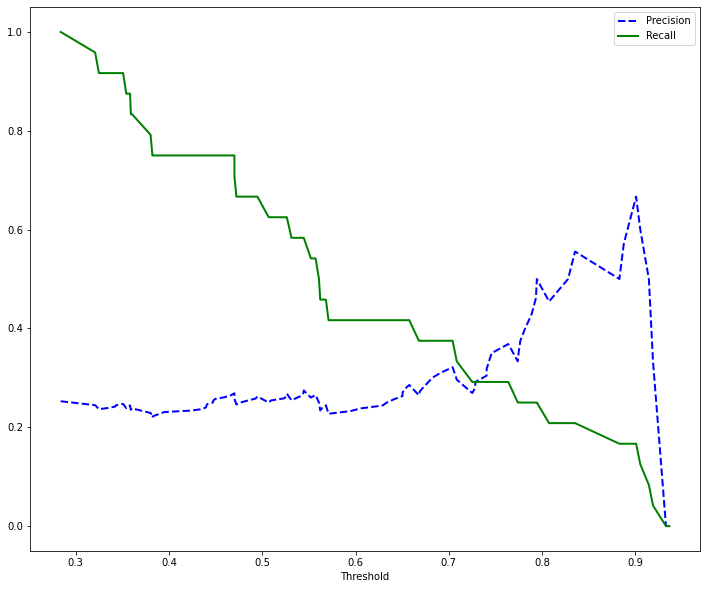

In [187]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
#plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
#[...]  # beautify the figure: add grid, legend, axis, labels, and circles
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [199]:
idx_for_75_recall = recalls[recalls>=0.75].shape[0]-1
threshold_for_75_recall = thresholds[idx_for_75_recall]
print(f" Threshold for 75% recall {threshold_for_75_recall}")
print(f"Precision: {precisions[idx_for_75_recall]}")
print(f"Recall: {recalls[idx_for_75_recall]}")


 Threshold for 75% recall 0.47001102566719055
Precision: 0.26865671641791045
Recall: 0.75


In [201]:
confusion_matrix(y_test,np.where(test_predictions_weighted > threshold_for_75_recall,1,0))

array([[26, 49],
       [ 7, 17]], dtype=int64)

Legitimate Transactions Detected (True Negatives):  26
Legitimate Transactions Incorrectly Detected (False Positives):  49
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  17
Total Fraudulent Transactions:  24


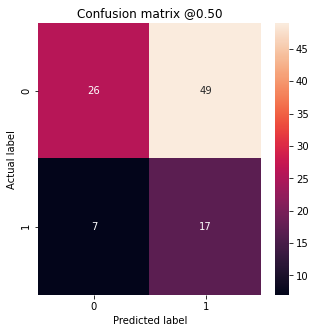

In [202]:
plot_cm(y_test, np.where(test_predictions_weighted > threshold_for_75_recall,1,0))

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

### Plot the ROC

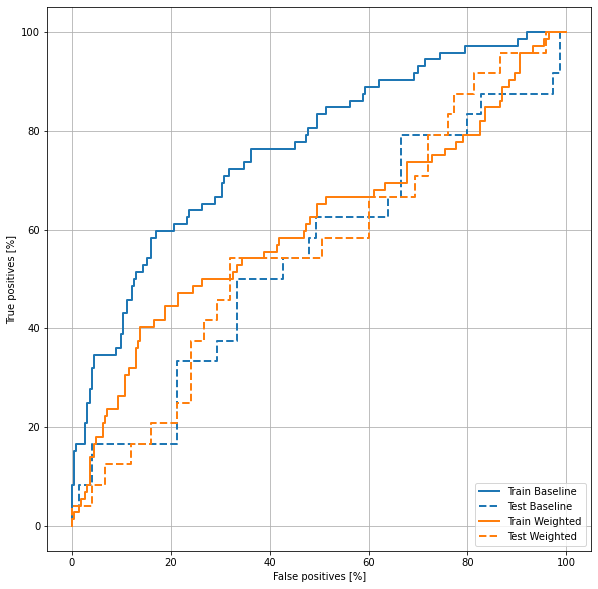

In [104]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### Plot the AUPRC

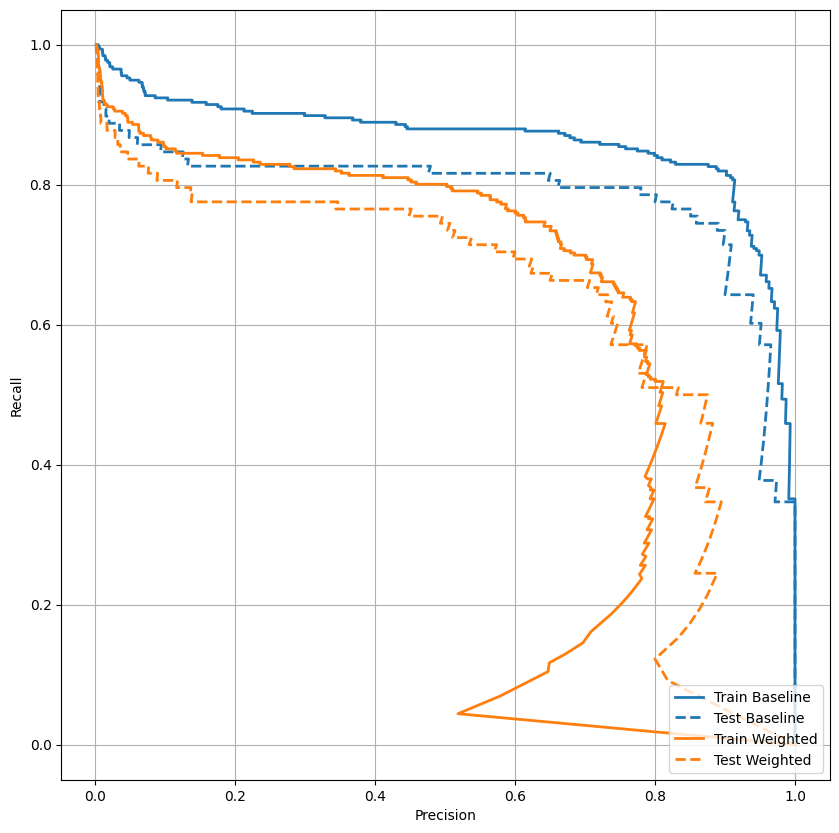

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [42]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181960, 29)

In [43]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363920, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [44]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [45]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 0.55048622  0.58281053 -0.18054636  1.93583095  0.29554659 -0.23724915
  0.03108875  0.14900966 -0.87832068 -0.17802301  2.09779545 -0.27353277
 -1.19726626 -1.95269012  0.43650731  1.5548122   1.78388368  1.22320993
 -1.93671114 -0.22109894 -0.01110755 -0.07843217 -0.08560816 -0.04293247
  0.76732118  0.15200643  0.06685898  0.18756067 -4.85856533]

Label:  1


Merge the two together using `tf.data.Dataset.sample_from_datasets`:

In [46]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [47]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.52490234375


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [48]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [49]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 8s 22ms/step - loss: 0.3953 - tp: 266190.0000 - fp: 98443.0000 - tn: 243783.0000 - fn: 17890.0000 - accuracy: 0.8143 - precision: 0.7300 - recall: 0.9370 - auc: 0.9499 - prc: 0.9521 - val_loss: 0.2553 - val_tp: 71.0000 - val_fp: 1519.0000 - val_tn: 43972.0000 - val_fn: 7.0000 - val_accuracy: 0.9665 - val_precision: 0.0447 - val_recall: 0.9103 - val_auc: 0.9714 - val_prc: 0.7439
Epoch 2/100
278/278 [==============================] - 6s 21ms/step - loss: 0.1833 - tp: 267167.0000 - fp: 16878.0000 - tn: 267871.0000 - fn: 17428.0000 - accuracy: 0.9397 - precision: 0.9406 - recall: 0.9388 - auc: 0.9824 - prc: 0.9856 - val_loss: 0.1188 - val_tp: 70.0000 - val_fp: 945.0000 - val_tn: 44546.0000 - val_fn: 8.0000 - val_accuracy: 0.9791 - val_precision: 0.0690 - val_recall: 0.8974 - val_auc: 0.9720 - val_prc: 0.7543
Epoch 3/100
278/278 [==============================] - 6s 21ms/step - loss: 0.1389 - tp: 270484.0000 - fp: 10829.0000 - tn: 27356

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

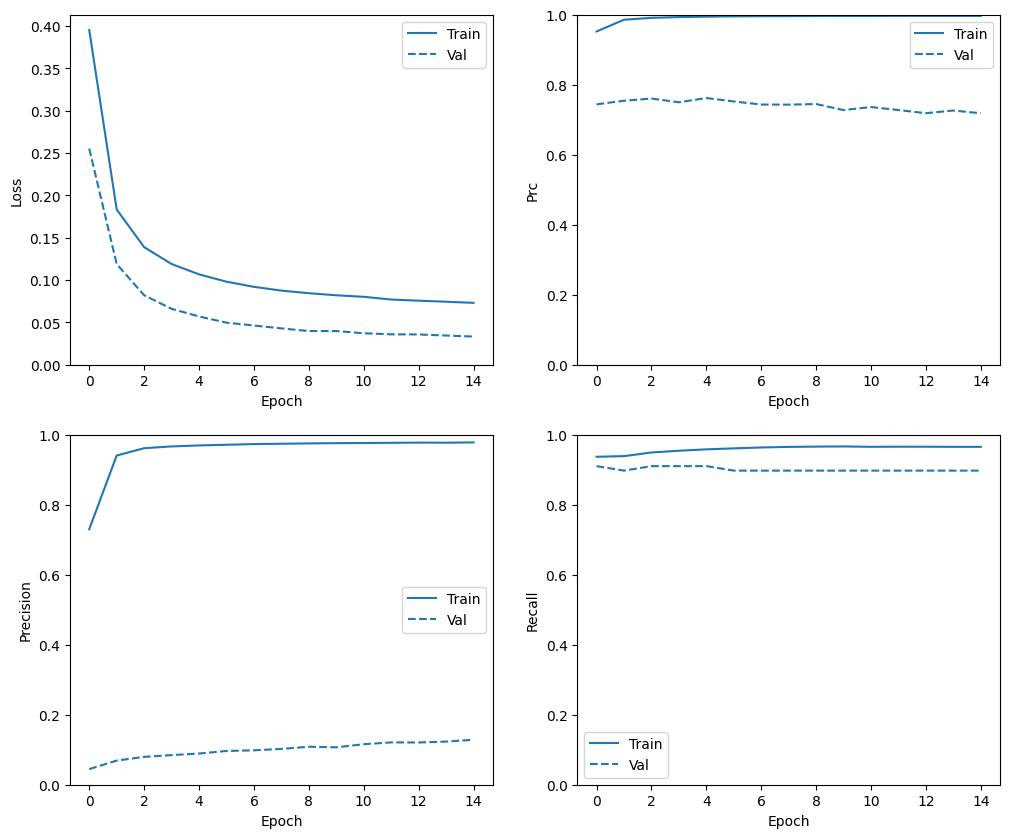

In [50]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `tf.keras.callbacks.EarlyStopping` finer control over when to stop training.

In [51]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 2s 48ms/step - loss: 0.7082 - tp: 19210.0000 - fp: 16080.0000 - tn: 49818.0000 - fn: 1421.0000 - accuracy: 0.7977 - precision: 0.5443 - recall: 0.9311 - auc: 0.9420 - prc: 0.8495 - val_loss: 1.0950 - val_tp: 77.0000 - val_fp: 37185.0000 - val_tn: 8306.0000 - val_fn: 1.0000 - val_accuracy: 0.1840 - val_precision: 0.0021 - val_recall: 0.9872 - val_auc: 0.9385 - val_prc: 0.1285
Epoch 2/1000
20/20 [==============================] - 0s 25ms/step - loss: 0.6165 - tp: 19339.0000 - fp: 14306.0000 - tn: 6312.0000 - fn: 1003.0000 - accuracy: 0.6262 - precision: 0.5748 - recall: 0.9507 - auc: 0.8784 - prc: 0.9025 - val_loss: 0.9397 - val_tp: 77.0000 - val_fp: 32360.0000 - val_tn: 13131.0000 - val_fn: 1.0000 - val_accuracy: 0.2898 - val_precision: 0.0024 - val_recall: 0.9872 - val_auc: 0.9517 - val_prc: 0.2705
Epoch 3/1000
20/20 [==============================] - 0s 25ms/step - loss: 0.5398 - tp: 19449.0000 - fp: 12293.0000 - tn: 8103.0000 - fn

Epoch 20/1000
20/20 [==============================] - 1s 26ms/step - loss: 0.1887 - tp: 19314.0000 - fp: 1251.0000 - tn: 19127.0000 - fn: 1268.0000 - accuracy: 0.9385 - precision: 0.9392 - recall: 0.9384 - auc: 0.9810 - prc: 0.9848 - val_loss: 0.1683 - val_tp: 71.0000 - val_fp: 1098.0000 - val_tn: 44393.0000 - val_fn: 7.0000 - val_accuracy: 0.9758 - val_precision: 0.0607 - val_recall: 0.9103 - val_auc: 0.9725 - val_prc: 0.7634
Epoch 21/1000
20/20 [==============================] - 0s 25ms/step - loss: 0.1808 - tp: 19232.0000 - fp: 1134.0000 - tn: 19326.0000 - fn: 1268.0000 - accuracy: 0.9414 - precision: 0.9443 - recall: 0.9381 - auc: 0.9827 - prc: 0.9860 - val_loss: 0.1600 - val_tp: 70.0000 - val_fp: 1081.0000 - val_tn: 44410.0000 - val_fn: 8.0000 - val_accuracy: 0.9761 - val_precision: 0.0608 - val_recall: 0.8974 - val_auc: 0.9729 - val_prc: 0.7634
Epoch 22/1000
20/20 [==============================] - 0s 25ms/step - loss: 0.1745 - tp: 19270.0000 - fp: 1069.0000 - tn: 19396.0000 - f

### Re-check training history

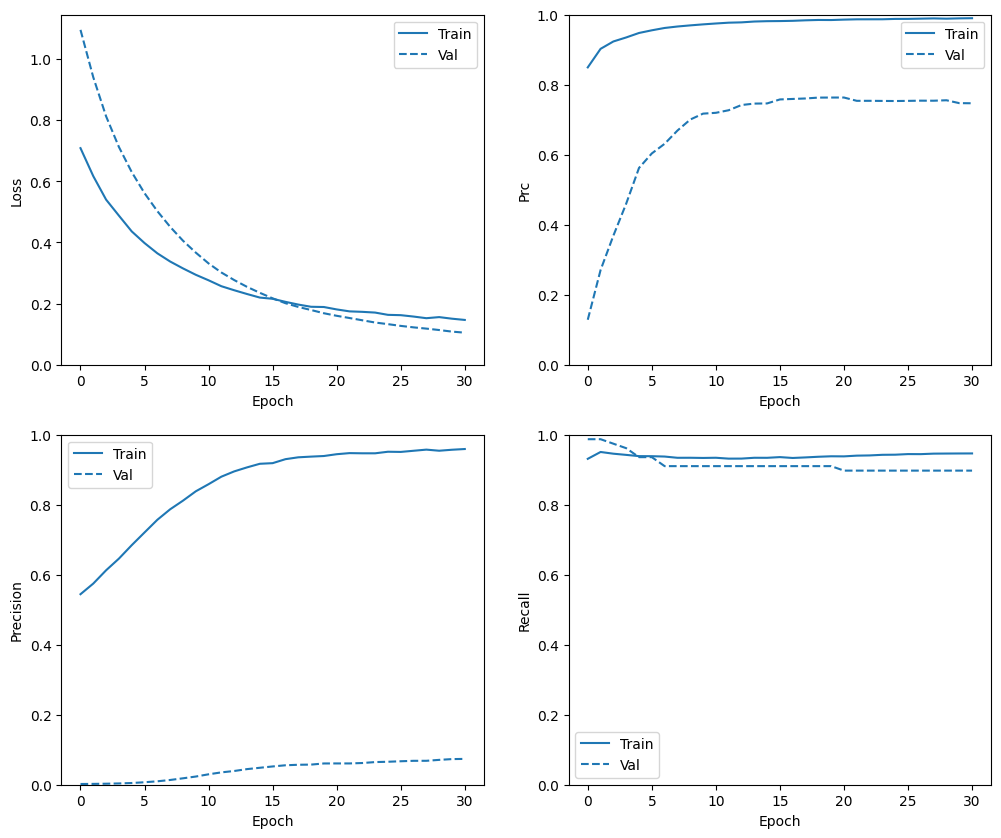

In [52]:
plot_metrics(resampled_history)

### Evaluate metrics

In [53]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


loss :  0.15973372757434845
tp :  84.0
fp :  1356.0
tn :  55508.0
fn :  14.0
accuracy :  0.9759488701820374
precision :  0.05833333358168602
recall :  0.8571428656578064
auc :  0.9540590047836304
prc :  0.6833170056343079

Legitimate Transactions Detected (True Negatives):  55508
Legitimate Transactions Incorrectly Detected (False Positives):  1356
Fraudulent Transactions Missed (False Negatives):  14
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  98


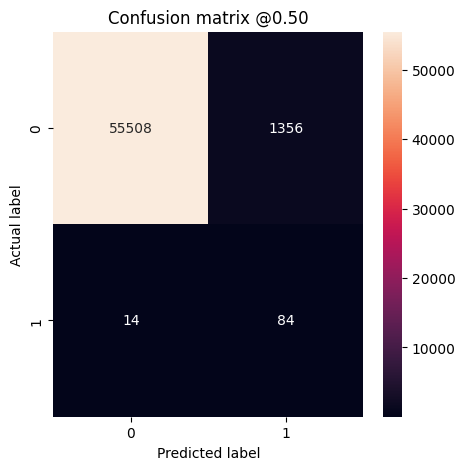

In [54]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

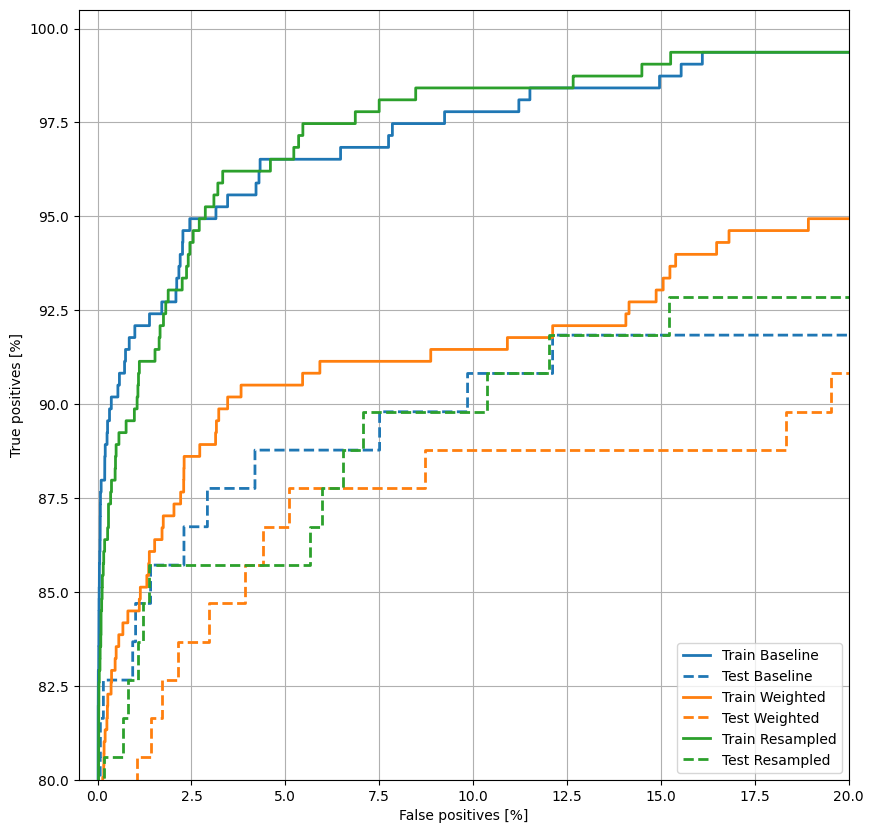

In [55]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC


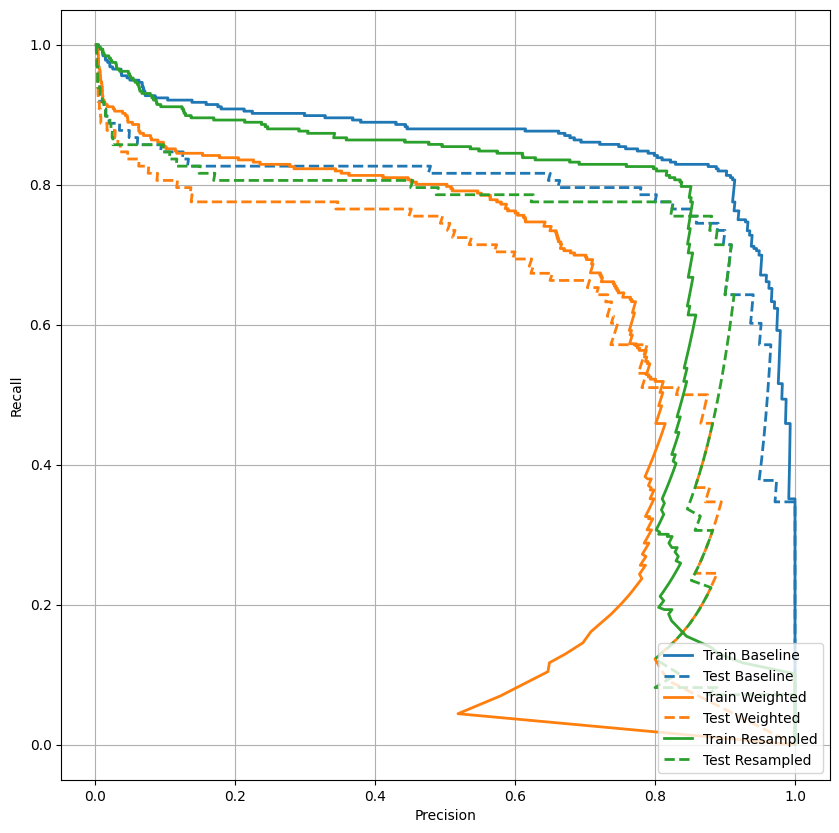

In [56]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.